In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl


import seaborn as sb
# sb.set_context("paper")

import math

torch.set_default_dtype(torch.float64)

In [ ]:
def sin_data(n, d=20, noise=0.0):
    # returns n samples (x,y) of sin function
    rng = np.random.default_rng(seed=42)

    x_np = rng.random(size=(n,d))
    y_np = np.sin((np.pi / d) * np.linalg.norm(x_np, axis=1) ** 2)

    x = torch.as_tensor(x_np.reshape(len(x_np),-1), device='cuda')
    x.requires_grad_(False)

    y = torch.as_tensor(y_np.reshape(len(y_np),-1), device='cuda') + noise * torch.as_tensor(rng.normal(0.0, 1.0, (n, 1)), device='cuda')
    y.requires_grad_(False)

    return x, y

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def realizable_data(n, d=20, width=100, noise=0.0):
    # returns n samples (x,y) of sin function
    # y = sin(pi . ||x||^2 / d)
    rng = np.random.default_rng(seed=16)
    Bx = np.sqrt(d)

    W_0 = torch.as_tensor(rng.normal(0.0, 1.0, (width, d)) / np.sqrt(width), device='cuda')
    W_0.requires_grad_(False)
    a_0 = torch.as_tensor(rng.normal(0.0, 1.0, (1, width)) / np.sqrt(width), device='cuda')
    a_0 = torch.div(a_0, torch.linalg.vector_norm(a_0) * Bx)
    a_0.requires_grad_(False)

    x = torch.as_tensor(rng.random(size=(n, d)), device='cuda')
    x.requires_grad_(False)

    with torch.no_grad():
      y = torch.sigmoid(F.linear(input=x, weight=W_0)).mm(a_0.t()) + noise * torch.as_tensor(rng.normal(0.0, 1.0, (n, 1)), device='cuda')
    y.requires_grad_(False)

    return x, y

In [ ]:
def train_neuralnet(X, Y, c_reg, batch_size=16, lr=1e-2, m=80, d=20, test_frac=0.2, T=50000, rng_seed=42):
    '''
        This function runs a simple one layer neural network on the training set (X,Y) where X and Y are vectors of n samples
        m is the number of hidden units, T is the number of iterations
        returns the predictors for X
    '''

    train_loss_reg = []
    train_loss_unreg = []
    test_loss_unreg = []

    rng = np.random.default_rng(seed=rng_seed)
    Bx = np.sqrt(d)
    # print(f"W: {rng.normal(0.0, 1.0, (m, d)) / np.sqrt(m)}")

    W = torch.as_tensor(rng.normal(0.0, 1.0, (m, d)) / np.sqrt(m), device = 'cuda')
    W.requires_grad_(True)
    # weights of the first layer a m x dim matrix whose each entry ~ 1/sqrt{m}*N(0,1)
    a = torch.as_tensor(rng.normal(0.0, 1.0, (1, m)) / np.sqrt(m), device = 'cuda')
    # weights of the second layer ~ (1/sqrt{m})*N(0,1)
    a = torch.div(a, torch.linalg.vector_norm(a) * Bx)
    a.requires_grad_(False)
    # Normalize a s.t. ||a|| = 1/Bx

    stepsize = lr

    W0 = W.data
    # print(f"W at start: {W0}")

    # test_frac is the fraction of data that is used as test data
    X_te, Y_te = X[:int(X.shape[0]*test_frac)], Y[:int(X.shape[0]*test_frac)]
    X_tr, Y_tr = X[int(X.shape[0]*test_frac):], Y[int(X.shape[0]*test_frac):]
    print(f"Train samples: {X_tr.shape[0]}, Test samples: {X_te.shape[0]}")
    print(f"Stepsize: {lr}")

    dataloader = torch.utils.data.DataLoader(
        torch.cat((X_tr, Y_tr), dim=1),      # n x (d+1) tensor
        batch_size=batch_size,
        shuffle=True
    )

    for i in range(T):
      for idx, batch in enumerate(dataloader):
        # batch_x is B x d
        batch_x = batch[:, :-1]
        # batch_y is B x 1
        batch_y = batch[:, -1].reshape(-1, 1)

        train_output = torch.sigmoid(F.linear(input=batch_x, weight=W)).mm(a.t())
        loss = torch.mean((train_output-batch_y)**2) + (c_reg / 2) * torch.linalg.matrix_norm(W) ** 2

        # running gradient descent
        W.data = W.data - stepsize * grad(loss, W)[0]

      with torch.no_grad():
        epoch_train_pred = torch.sigmoid(F.linear(input=X_tr, weight=W)).mm(a.t())
        epoch_test_pred = torch.sigmoid(F.linear(input=X_te, weight=W)).mm(a.t())
        epoch_train_loss = (torch.mean((epoch_train_pred - Y_tr) ** 2) + (c_reg / 2) * torch.linalg.matrix_norm(W) ** 2).float().item()

      if i % 1000 == 0 or i == T-1:
        print(f"Epoch {i} -------- \nReg. train loss: {epoch_train_loss:.6f}")
        print(f"Unreg. train loss: {torch.mean((epoch_train_pred - Y_tr) ** 2).item():.6f}")
        print(f"Test loss: {torch.mean((epoch_test_pred - Y_te) ** 2).item():.6f}\n")


      train_loss_reg.append(epoch_train_loss)
      train_loss_unreg.append(torch.mean((epoch_train_pred - Y_tr) ** 2).item())
      test_loss_unreg.append(torch.mean((epoch_test_pred - Y_te) ** 2).item())

    del W, a
    return train_loss_reg, train_loss_unreg, test_loss_unreg

In [ ]:
def run_experiment(X, Y, n, m, T, lr, c_r, d, test_frac, batch_size=16):
    '''
        Generates inputs using the input generator and train a neural network to
        estimate the input. m is the number of hidden units, T is the number of
        iterations, n is the number of samples.
        Note: x, y = input_generator(n) where input_generator returns n input
        samples x, y where x is an indepedent RV, and y is the dependent one.
    '''
    rng = np.random.default_rng(seed=42)
    By = 0.3

    print(f"Using m={m}\n")

    test_losses = []

    # noise_frac = 1.0
    # noise_mask = torch.from_numpy(rng.choice([0.0, 1.0], size=Y.shape, p=[1-noise_frac, noise_frac])).to('cuda')
    # Y_noise = Y + noise_mask * torch.from_numpy(0.05 * rng.standard_cauchy(size=Y.shape)).to('cuda')
    # Y_noise = Y + torch.from_numpy(0.1 * rng.standard_normal(size=Y.shape)).to('cuda')

    for idx, lam in enumerate(c_r):
      print(f"Using c_reg = {lam}")

      for rng_seed in [42, 55, 23]:
        print(f"Using seed: {rng_seed}")
        test_losses_seed = []
        train_loss_reg, train_loss_unreg, test_loss_unreg = train_neuralnet(X, Y, lam, batch_size, lr[idx], m, d, test_frac, T, rng_seed)
        test_losses_seed.append(min(test_loss_unreg))

      test_losses.append(sum(test_losses_seed)/len(test_losses_seed))
    return test_losses

 ***NOTE : T specifies the number of passes through the data NOT the number of S.G.D. updates ***

## Experiments on Realizable Data

In [ ]:
n_samples = 2048
input_d = 20
# x, y = sin_data(n_samples, input_d, 0.5)
x, y = realizable_data(n_samples, input_d, 5, 0.1)
# x, y = noise_labels(2048, 20)

c_r_list = [1e-5, 1e-3, 1e-2, 1e-1, 0.13, 0.3]
lr_list = [0.8] * len(c_r_list)
test_losses_width = []

# 800, 1000, 2000, lr=0.8
# [5, 10, 100, 500, 1000], lr=0.01
for width in [100, 500, 800]:
  # x, y = realizable_data(2048, 20, width)
  test_losses_width.append(run_experiment(X=x, Y=y, n=n_samples, m=width, T=5000, lr=lr_list, c_r=c_r_list, d=input_d, test_frac=0.6, batch_size=32))
  print('-'*75 + '\n' + '-'*75)

Using m=100

Using c_reg = 1e-05
Using seed: 42
Train samples: 820, Test samples: 1228
Stepsize: 0.8
Epoch 0 -------- 
Reg. train loss: 0.018876
Unreg. train loss: 0.018775
Test loss: 0.017406

Epoch 1000 -------- 
Reg. train loss: 0.010878
Unreg. train loss: 0.010786
Test loss: 0.009707

Epoch 2000 -------- 
Reg. train loss: 0.010814
Unreg. train loss: 0.010728
Test loss: 0.009644

Epoch 3000 -------- 
Reg. train loss: 0.010786
Unreg. train loss: 0.010704
Test loss: 0.009619

Epoch 4000 -------- 
Reg. train loss: 0.010769
Unreg. train loss: 0.010691
Test loss: 0.009618

Epoch 4999 -------- 
Reg. train loss: 0.010756
Unreg. train loss: 0.010680
Test loss: 0.009616

Using seed: 55
Train samples: 820, Test samples: 1228
Stepsize: 0.8
Epoch 0 -------- 
Reg. train loss: 0.012893
Unreg. train loss: 0.012789
Test loss: 0.011624

Epoch 1000 -------- 
Reg. train loss: 0.010805
Unreg. train loss: 0.010721
Test loss: 0.009606

Epoch 2000 -------- 
Reg. train loss: 0.010782
Unreg. train loss: 0.0

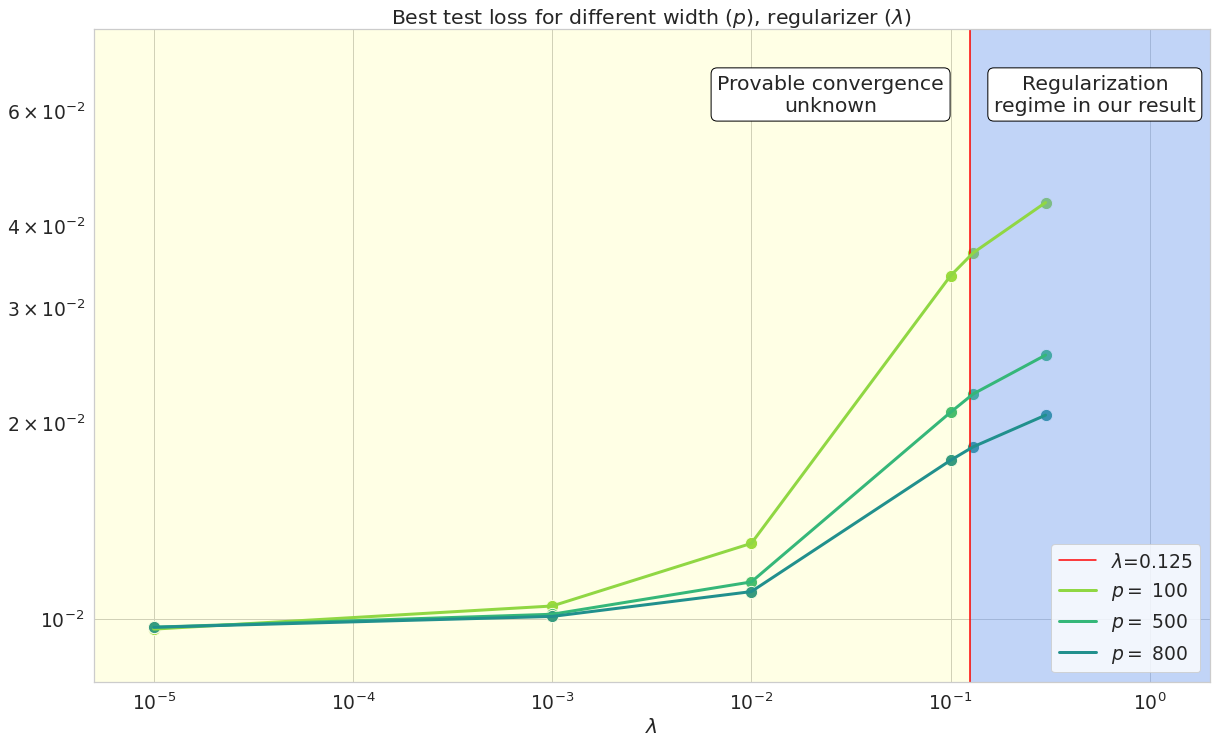

In [ ]:
sb.set_theme(style='whitegrid', font_scale=1.7)

with sb.color_palette('viridis_r', 5):
  fig = plt.figure(figsize=(20, 12))
  # fig.text(.5, .01, f'log-log plot (Test loss vs $\lambda$)', ha='center')
  plt.axvline(0.125, color='red', label=f'$\lambda$=0.125')

  for idx, width in enumerate([100, 500, 800]):
    sb.lineplot(x=c_r_list, y=test_losses_width[idx], linewidth=3, label=f'$p =$ {width}')
    sb.scatterplot(x=c_r_list, y=test_losses_width[idx], s=150)

  plt.title(f'Best test loss for different width ($p$), regularizer ($\lambda$)') #; label noise$ \sim$ Gaussian(0, 0.25)')
  plt.xlabel(f'$\lambda$')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(5e-6, 2.0)
  plt.ylim(8e-3, 0.08)
  # plt.xticks(c_r_list[1:])
  plt.text(0.53, 0.06, f'Regularization\nregime in our result', horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
  plt.text(0.025, 0.06, f'Provable convergence\nunknown', horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

  plt.fill_betweenx(x1=0.125, x2=2.1, y=np.arange(0.0, 3.0), color='cornflowerblue', alpha=0.4)
  plt.fill_betweenx(x1=5e-6, x2=0.125, y=np.arange(0.0, 3.0), color='yellow', alpha=0.1)

  plt.legend(loc=4)

## Experiments on Agnostic (sinusoid) data

In [ ]:
n_samples = 2048
input_d = 20
x, y = sin_data(n_samples, input_d, 0.5)
# x, y = realizable_data(n_samples, input_d, 5, 0.1)
# x, y = noise_labels(2048, 20)

c_r_list = [1e-5, 1e-3, 1e-2, 1e-1, 0.13, 0.3]
lr_list = [0.01] * len(c_r_list)
test_losses_width = []

# 800, 1000, 2000, lr=0.8
# [5, 10, 100, 500, 1000], lr=0.01
for width in [5, 10, 100, 500, 1000]:
  # x, y = realizable_data(2048, 20, width)
  test_losses_width.append(run_experiment(X=x, Y=y, n=n_samples, m=width, T=5000, lr=lr_list, c_r=c_r_list, d=input_d, test_frac=0.6, batch_size=32))
  print('-'*75 + '\n' + '-'*75)

Using m=5

Using c_reg = 1e-05
Using seed: 42
Train samples: 820, Test samples: 1228
Stepsize: 0.01
Epoch 0 -------- 
Reg. train loss: 0.805710
Unreg. train loss: 0.805649
Test loss: 0.890148

Epoch 1000 -------- 
Reg. train loss: 0.575944
Unreg. train loss: 0.575779
Test loss: 0.641941

Epoch 2000 -------- 
Reg. train loss: 0.573782
Unreg. train loss: 0.573581
Test loss: 0.639567

Epoch 3000 -------- 
Reg. train loss: 0.573083
Unreg. train loss: 0.572859
Test loss: 0.638787

Epoch 4000 -------- 
Reg. train loss: 0.572741
Unreg. train loss: 0.572499
Test loss: 0.638398

Epoch 4999 -------- 
Reg. train loss: 0.572539
Unreg. train loss: 0.572283
Test loss: 0.638165

Using seed: 55
Train samples: 820, Test samples: 1228
Stepsize: 0.01
Epoch 0 -------- 
Reg. train loss: 0.855597
Unreg. train loss: 0.855449
Test loss: 0.944359

Epoch 1000 -------- 
Reg. train loss: 0.533969
Unreg. train loss: 0.533740
Test loss: 0.595914

Epoch 2000 -------- 
Reg. train loss: 0.531360
Unreg. train loss: 0.5

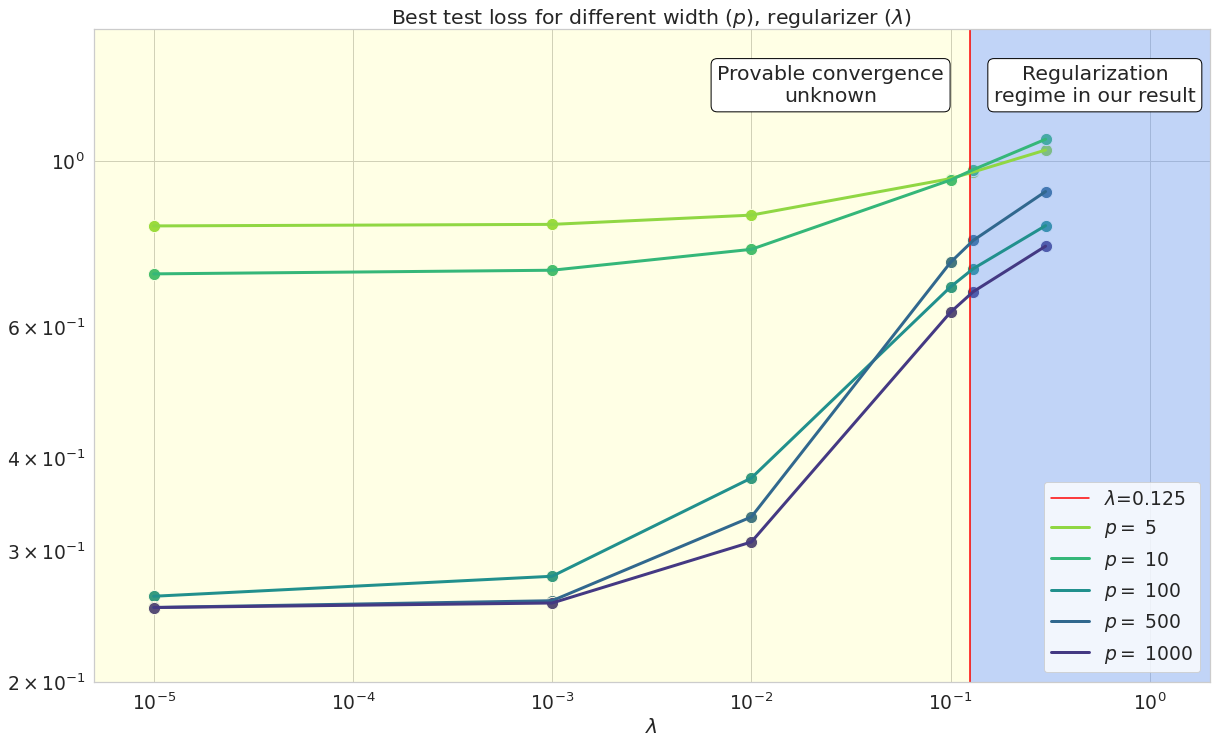

In [ ]:
sb.set_theme(style='whitegrid', font_scale=1.7)

with sb.color_palette('viridis_r', 5):
  fig = plt.figure(figsize=(20, 12))
  # fig.text(.5, .01, f'log-log plot (Test loss vs $\lambda$)', ha='center')
  plt.axvline(0.125, color='red', label=f'$\lambda$=0.125')

  for idx, width in enumerate([5, 10, 100, 500, 1000]):
    sb.lineplot(x=c_r_list, y=test_losses_width[idx], linewidth=3, label=f'$p =$ {width}')
    sb.scatterplot(x=c_r_list, y=test_losses_width[idx], s=150)

  plt.title(f'Best test loss for different width ($p$), regularizer ($\lambda$)') #; label noise$ \sim$ Gaussian(0, 0.25)')
  plt.xlabel(f'$\lambda$')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(5e-6, 2.0)
  plt.ylim(0.2, 1.5)
  # plt.xticks(c_r_list[1:])
  plt.text(0.53, 1.2, f'Regularization\nregime in our result', horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
  plt.text(0.025, 1.2, f'Provable convergence\nunknown', horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

  plt.fill_betweenx(x1=0.125, x2=2.1, y=np.arange(0.0, 3.0), color='cornflowerblue', alpha=0.4)
  plt.fill_betweenx(x1=5e-6, x2=0.125, y=np.arange(0.0, 3.0), color='yellow', alpha=0.1)

  plt.legend()